In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 

from iemm import IEMM, Loss

In [3]:
if 'experiment_name' not in globals():
    from evclust.ecm import ecm

    folder_figs = None

    df = pd.read_csv('data/easy_synth_data.csv')
    feature_names = df.columns[:-1].to_list()
    features = df.iloc[:, :-1].values

    number_clusters = 2
    model = ecm(x=features, c=number_clusters, beta = 2,  alpha=1, delta=3, disp=False)

    # model_names : (mass, F, lambda_num)
    masses_to_test = {
        'easy': (model['mass_n'], model['F'][1:], 1),
    }
    cmap = 'Set1'
features_dimension = features.shape[1]
if features_dimension == 2:
    features_labels = ['x','y']
else:
    features_labels = [f'x_{i}' for i in range(features_dimension)]

if 'cmap' not in globals():
    cmap = 'personalized'

In [4]:
def get_style(F, cmap):    
    number_metaclusters = len(F)
    number_clusters = len(F[0])
    
    if number_clusters == 3 and cmap == 'Pastel1':
        cmap = plt.get_cmap(cmap)
        cluster_base_colors = [np.array(cmap(1)), np.array(cmap(2)), np.array(cmap(0))]
        cardinality_indication_color = np.array(cmap(7))
        cardinality_indication_color = np.array([1, 1, 1, 1])
    if number_clusters == 3 and cmap == 'Set1':
        cmap = plt.get_cmap(cmap)
        cluster_base_colors = [np.array(cmap(1)), np.array(cmap(2)), np.array(cmap(4))]
        cardinality_indication_color = np.array(cmap(7))
        cardinality_indication_color = np.array([0.9, 0.9, 0.9, 1])
    if number_clusters == 3 and cmap == 'personalized':
        cluster_base_colors = [
            np.array([73, 80, 182, 255])/255,
            np.array([182, 73, 80, 255])/255,
            np.array([80, 182, 73, 255])/255,
        ]
        # cluster_base_colors = [
        #     np.array([132, 51, 62, 255])/255,
        #     np.array([51, 62, 132, 255])/255,
        #     np.array([62, 132, 51, 255])/255,
        # ]
        cardinality_indication_color = np.array([0.9, 0.9, 0.9, 1])
    else:
        cmap = plt.get_cmap(cmap)
        cluster_base_colors = [np.array(cmap(i)) for i in range(len(F))]
        cardinality_indication_color = np.array(cmap(number_metaclusters))
    focal_colors = []

    for f in F:
        color = np.array([0., 0., 0., 0.])
        for i in range(len(f)):
            if f[i] == 1:
                color += cluster_base_colors[i]
        color = color/np.sum(f)

        color = color + (cardinality_indication_color - color) * (np.sum(f)-1)/(number_clusters-1)

        focal_colors.append(color)
    focal_colors[0] = cluster_base_colors[0]
    
    # formatting focal sets for printing
    focal_sets = [" \\cup ".join(["\\omega_{" + str(i+1) + "}" for i in range(len(f)) if f[i] == 1]) for f in F]
    mass_focal_sets = ['$m_{'+focal_sets[i]+'}$' for i in range(number_clusters)]
    focal_sets = ['$'+f+'$' for f in focal_sets]

    return focal_colors, focal_sets, mass_focal_sets

In [5]:
def get_centroids(F, masses):
    """
    Compute the centroids of the clusters based on the focal sets and their masses.
    """
    metacluster_centroids = []
    for i in range(len(F)):
        if np.sum(F[i]) > 0:
            centroid = np.zeros(features.shape[1])
            for point in range(features.shape[0]):
                centroid += features[point] * masses[point, i]
            centroid /= np.sum(masses[:, i])
            metacluster_centroids.append(centroid)
    metacluster_centroids = np.array(metacluster_centroids)

    return metacluster_centroids

In [6]:
def get_colors(focal_colors, masses):    
    colors = []
    for point in range(len(features)):
        color = np.sum([focal_colors[i] * masses[point, i] for i in range(len(focal_colors))], axis=0)
        color = np.clip(color, 0, 1)
        color = color[:3]
        colors.append(color)

    return colors

In [7]:
def explore_iemm(mass, F, model_name, lambdas, ax=None):
    # getting the colorscheme and focal sets names
    focal_colors, focal_sets, mass_focal_sets = get_style(F, cmap=cmap)

    diagram_args = {
        'class_names' : mass_focal_sets,
        'cluster_names' : focal_sets,
        'feature_names' : feature_names,
    }
    
    if not ax is None:
        diagram_args['focal_colors'] = focal_colors

        # getting centroids
        metacluster_centroids = get_centroids(F, mass)

        # getting each point color
        colors = get_colors(focal_colors, mass)

        # plotting points
        ax[0].set_title(f"$\mathcal{{M}}_{{{model_name}}}$")
        for i in range(len(features)):
            ax[0].scatter(features[i, 0], features[i, 1], color=colors[i], edgecolor='black', linewidth=0.5)
        # informing the legend
        for i in range(len(focal_sets)):
            ax[0].scatter([], [], color=focal_colors[i], label=focal_sets[i])
        # plot centroids
        for i in range(len(metacluster_centroids)):
            ax[0].scatter(metacluster_centroids[i, 0], metacluster_centroids[i, 1], color=focal_colors[i], edgecolor='black', marker='*', s=200)
        # remove ticks
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        # get the limits
        xmin, xmax = ax[0].get_xlim()
        ymin, ymax = ax[0].get_ylim()

    diagrams, paths, pred_metaclusters = {}, {}, {}
    idx_img = 0
    for lambda_mistakeness in lambdas:
        # goes to next plot
        idx_img += 1

        # getting the IEMM classifier
        classifier = IEMM(lambda_mistakeness=lambda_mistakeness)

        y = mass.copy()
        classifier.fit(features, y, F)
        diagram = classifier.plot_tree(
            **diagram_args
        )
        diagrams[lambda_mistakeness] = diagram

        pred_metaclusters[lambda_mistakeness] = classifier.predict(features).reshape(-1)

        # getting the path (that is, the explanation) for each metacluster
        try:
            path = classifier.get_path(features_labels, focal_sets)
            paths[lambda_mistakeness] = path
        except:
            paths[lambda_mistakeness] = []
        # saving the diagram
        if folder_figs is not None:
            os.makedirs(f'{folder_figs}/{model_name}', exist_ok=True)
            diagram.save(f'{folder_figs}/{model_name}/diagram_{lambda_mistakeness}.pdf')

        if not ax is None:
            # plotting the regions
            X, Y = np.meshgrid(np.linspace(xmin, xmax, 100), np.linspace(ymin, ymax, 100))
            features_xy = np.column_stack((X.ravel(), Y.ravel()))
            Z_metclus = classifier.predict(features_xy).reshape(X.shape[0], X.shape[1], -1)
            Z_color = np.zeros((X.shape[0], X.shape[1], 3))
            for i in range(X.shape[0]):
                for j in range(X.shape[1]):
                    Z_color[i, j] = focal_colors[Z_metclus[i, j, 0]][:3]
            ax[idx_img].imshow(Z_color, extent=(xmin, xmax, ymin, ymax), origin='lower', aspect='auto')

            # defining the title
            if lambda_mistakeness == np.inf:
                title = f'$M^\infty_{{\mathcal{{M}}_{{{model_name}}}}}$'
            elif lambda_mistakeness == -np.inf:
                title = f'$M^{{-\infty}}_{{\mathcal{{M}}_{{{model_name}}}}}$'
            else:
                title = f'$M^{{{lambda_mistakeness}}}_{{\mathcal{{M}}_{{{model_name}}}}}$'
            ax[idx_img].set_title(title)
            # defining the limits
            ax[idx_img].set_xticks([])
            ax[idx_img].set_yticks([])
            # scatter the data
            for i in range(len(features)):
                ax[idx_img].scatter(features[i, 0], features[i, 1], color=colors[i], edgecolor='black', linewidth=0.5)
            # plot centroids
            for i in range(len(metacluster_centroids)):
                ax[idx_img].scatter(metacluster_centroids[i, 0], metacluster_centroids[i, 1], color=focal_colors[i], edgecolor='black', marker='*', s=200)
        
    # paths to df
    paths_df = pd.DataFrame()
    for lambda_mistakeness in paths.keys():
        path = paths[lambda_mistakeness]
        p = {}
        for d in path:
            for k, v in d.items():
                p.setdefault(k, []).append(v)
        df = pd.DataFrame(p)
        if lambda_mistakeness == np.inf:
            title = f'$M^\infty_{{\mathcal{{M}}_{{{model_name}}}}}$'
        elif lambda_mistakeness == -np.inf:
            title = f'$M^{{-\infty}}_{{\mathcal{{M}}_{{{model_name}}}}}$'
        else:
            title = f'$M^{{{lambda_mistakeness}}}_{{\mathcal{{M}}_{{{model_name}}}}}$'
        df.index = [title]
        paths_df = pd.concat([paths_df, df])        

    return paths_df, diagrams, pred_metaclusters

In [8]:
def evaluate(mass, pred_metaclusters, F, lambda_):
    okness = 0
    for point in range(len(pred_metaclusters)):
        for metacluster in range(len(F)):
            S = Loss.S(F[pred_metaclusters[point]], F[metacluster], lambda_)
            okness += mass[point, metacluster] * S
    return okness / len(pred_metaclusters)

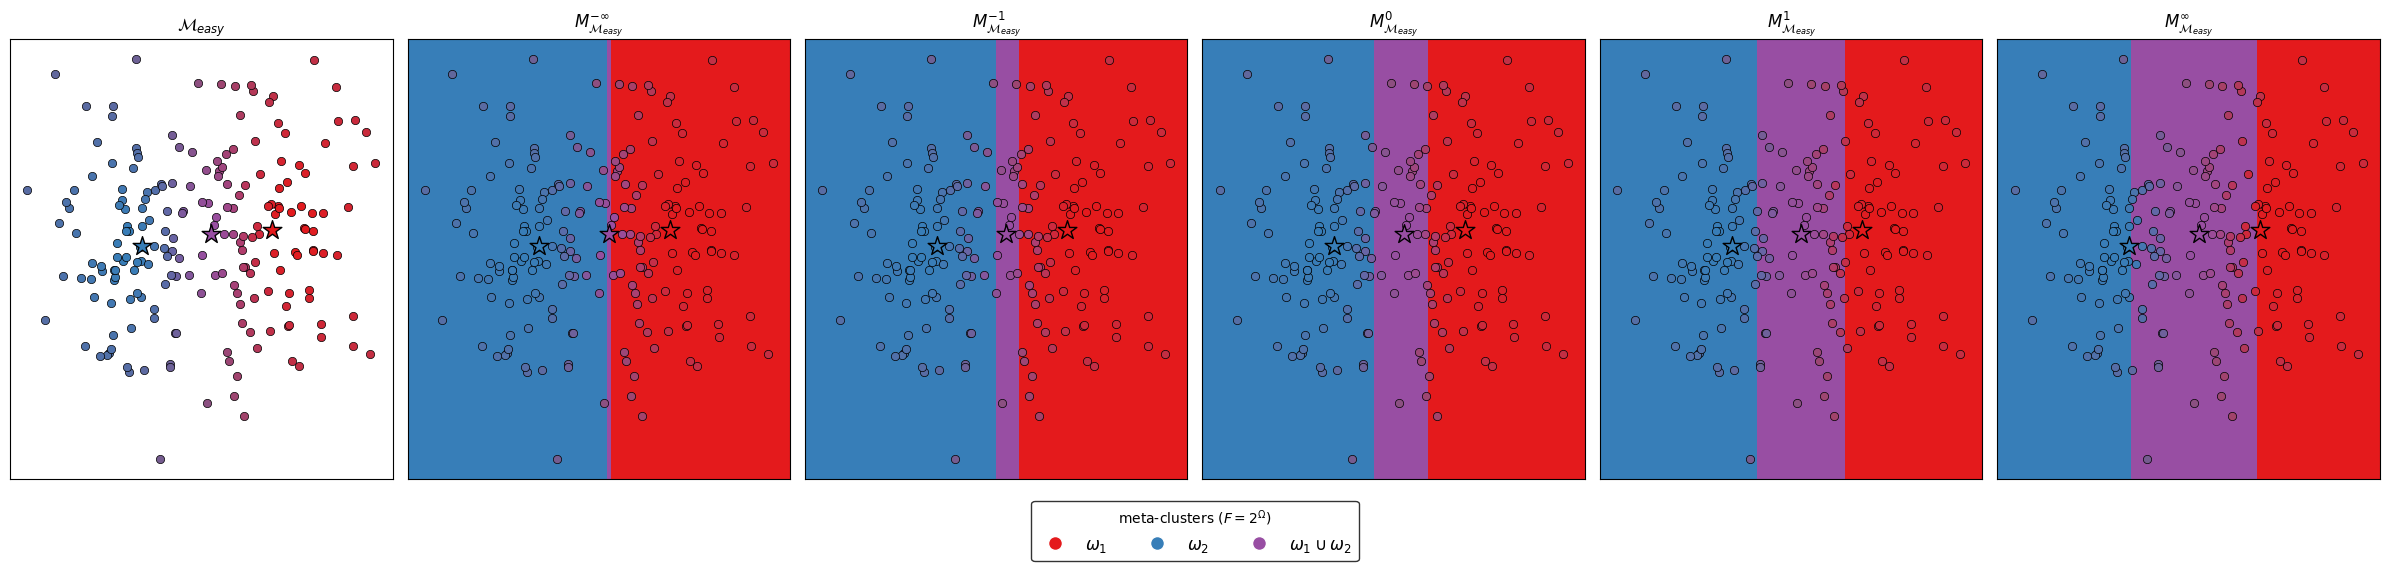

In [9]:
number_experiments = len(masses_to_test)
if features_dimension == 2:
    fig, ax = plt.subplots(number_experiments, 6, figsize=(24, 5*len(masses_to_test)), sharex=True, sharey=True)

i = 0
scores = {}
paths_df_ = {}
for model_name, (mass, F, lambda_num) in masses_to_test.items():
    # test the model for different lambda values
    all_lambdas = [-np.inf, -lambda_num, 0, lambda_num, np.inf]

    if features_dimension == 2:
        if number_experiments == 1:
            ax_ = ax
        else:
            ax_ = ax[i, :]
    else:
        ax_ = None

    paths_df, diagrams, pred_metaclusters = explore_iemm(mass, F, model_name, all_lambdas, ax=ax_)
    i += 1

    paths_df_.update({model_name: paths_df})
    if folder_figs is not None:
        os.makedirs(folder_figs, exist_ok=True)
        # to latex
        paths_df.to_latex(f'{folder_figs}/{model_name}_paths.tex', escape=False, index=True, float_format="%.2f")

    scores[model_name] = {}
    for lambda_eval in all_lambdas:
        scores[model_name][lambda_eval] = {}
        for lambda_iemm in all_lambdas:
            scores[model_name][lambda_eval][lambda_iemm] = evaluate(mass, pred_metaclusters[lambda_iemm], F, lambda_eval)
            # print(f'lambda_eval: {lambda_eval}, lambda_iemm: {lambda_iemm}, score: {scores[model_name][lambda_eval][lambda_iemm]}')

if features_dimension == 2:
    if number_experiments == 3:
        anchor = (0.5, -0.05)
    elif number_experiments == 1:
        anchor = (0.5, -0.15)
    else:
        anchor = (0.5, -0.08)

    focal_colors, focal_sets, mass_focal_sets = get_style(F, cmap=cmap)
    lgd = fig.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label=focal_sets[i], markerfacecolor=focal_colors[i], markersize=10) for i in range(len(focal_sets))]
                                ,edgecolor='black', loc='lower center', ncol=len(focal_sets), fontsize='large', title='meta-clusters ($F = 2^\Omega$)', bbox_to_anchor=anchor)
    plt.tight_layout()
    
    if folder_figs is not None:
        os.makedirs(folder_figs, exist_ok=True)
        fig.savefig(f'{folder_figs}/points_plot.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

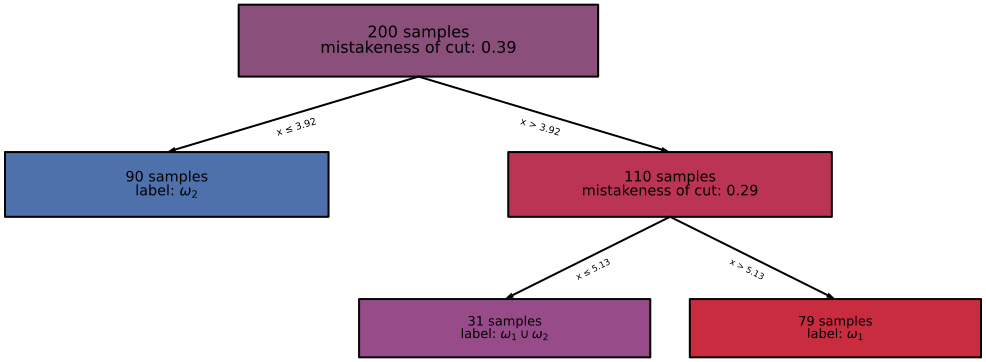

In [10]:
# simple
diagrams[0]

In [11]:
diagrams[0].save('figs/diagram_simple_0.pdf')

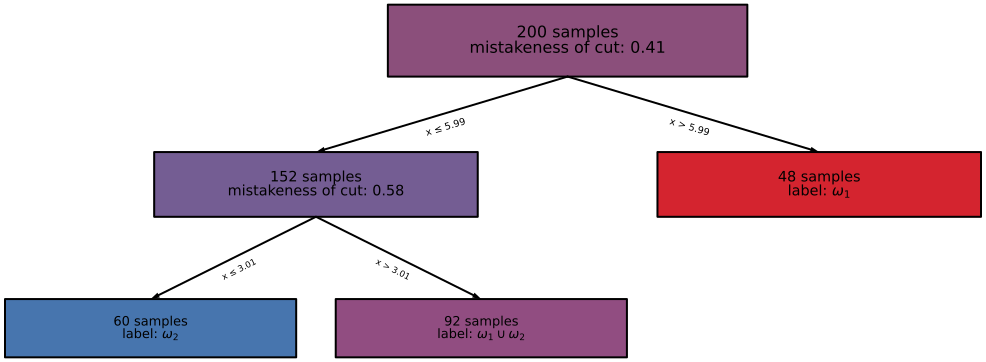

In [12]:
# simple
diagrams[np.inf]

In [13]:
for s in scores.keys():
    display(s)
    display(pd.DataFrame(scores[s]))
    display(paths_df_[s])

'easy'

,-inf,-1.0,0.0,1.0,inf
-inf,0.915796,0.808588,0.701380,0.701452,0.701524
-1.0,0.901122,0.819012,0.736903,0.749377,0.761850
0.0,0.876733,0.813867,0.751002,0.781731,0.812461
1.0,0.781247,0.751198,0.721149,0.811562,0.901975
inf,0.689432,0.669249,0.649067,0.789613,0.930160


,$\omega_{2}$,$\omega_{1} \cup \omega_{2}$,$\omega_{1}$
$M^{-\infty}_{\mathcal{M}_{easy}}$,$(x \leq 4.58)$,$(x > 4.58) \wedge (x \leq 4.67)$,$(x > 4.67)$
$M^{-1}_{\mathcal{M}_{easy}}$,$(x \leq 4.33)$,$(x > 4.33) \wedge (x \leq 4.91)$,$(x > 4.91)$
$M^{0}_{\mathcal{M}_{easy}}$,$(x \leq 3.92)$,$(x > 3.92) \wedge (x \leq 5.13)$,$(x > 5.13)$
$M^{1}_{\mathcal{M}_{easy}}$,$(x \leq 3.57)$,$(x \leq 5.65) \wedge (x > 3.57)$,$(x > 5.65)$
$M^\infty_{\mathcal{M}_{easy}}$,$(x \leq 3.01)$,$(x \leq 5.99) \wedge (x > 3.01)$,$(x > 5.99)$
